<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных-к-обучению" data-toc-modified-id="Подготовка-данных-к-обучению-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных к обучению</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-предпросмотр" data-toc-modified-id="Загрузка-и-предпросмотр-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и предпросмотр</a></span></li><li><span><a href="#Подготовка-текста" data-toc-modified-id="Подготовка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Импорт библиотек:**

In [1]:
import pandas as pd

! pip install pymystem3 -q
from pymystem3 import Mystem

import re

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
from nltk.corpus import wordnet, stopwords
nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

from joblib import Parallel, delayed

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/dormak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/dormak/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dormak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dormak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/dormak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/dormak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка данных к обучению

### Загрузка и предпросмотр

Загрузим предоставленную таблицу с локального источника или онлайн:

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('datasets/toxic_comments.csv', index_col=0)

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Таблица содержит 159292 размеченных по тональности комментариев. Нулевых строк не наблюдаем.

In [5]:
df['length'] = df['text'].apply(len)

In [6]:
df['length'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: length, dtype: float64

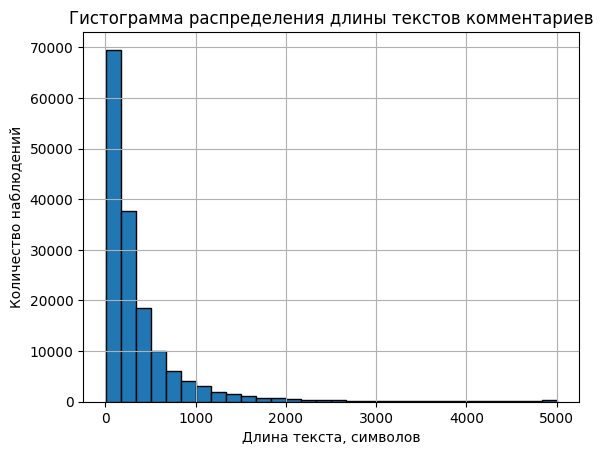

In [7]:
df['length'].hist(bins=30, edgecolor='black', grid=True)
plt.xlabel('Длина текста, символов')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения длины текстов комментариев')
plt.show()

Все наши комментарии не меньше 5 символов, встречаются и огромные тексты в 5000. В среднем тексты не превышают 400 символов.

In [8]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Большинство комментариев в таблице имеют положительную оценку. Поэтому таргет несбалансированный, стоит это учесть про формировании тренировочной и тестовой выборок и настройки модели.

**Вывод:** из исходных данных получили 159292 размеченных комментариев. Датасет не содержит поврежденных или нулевых данных. Наблюдаем значительный дисбаланс в данных.

### Подготовка текста

Проведем очиcтку и лемматизацию текста: воспользуемся библиотекой `pymystem3`.

In [9]:
m = Mystem()

Лемматизируем, очистим от ненужных символов и приведем в нижний регистр:

In [10]:
def prepare_text(text):
    
    lemm_list = m.lemmatize(text)
    lemm_text = ''.join(lemm_list)
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text).lower().split()
    
    return " ".join(cleared_text)

In [11]:
%%time
df['mystem'] = df['text'].head(1000).apply(prepare_text)

CPU times: user 106 ms, sys: 19.6 ms, total: 126 ms
Wall time: 734 ms


Данная библиотека хорошо лемматизирует русские тексты, посмотрим на результат обработки тектса на английском языке:

In [12]:
df['mystem'][14]

'oh and the girl above started her arguments with me she stuck her nose where it doesn t belong i believe the argument was between me and yvesnimmo but like i said the situation was settled and i apologized thanks'

In [13]:
df['text'][14]

"Oh, and the girl above started her arguments with me. She stuck her nose where it doesn't belong. I believe the argument was between me and Yvesnimmo. But like I said, the situation was settled and I apologized. Thanks,"

Данные тексты никак не отличаются по форме слов. Используем для лемматизации другую библиотеку:

In [14]:


def get_wordnet_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

def lemmatize_nltk(text):

    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    lemmatizer = WordNetLemmatizer()

    lemmas = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]
    return ' '.join(lemmas)

In [15]:
%%time
df['nltk'] = df['text'].head(1000).apply(lemmatize_nltk)

CPU times: user 3.59 s, sys: 66.9 ms, total: 3.65 s
Wall time: 3.66 s


In [16]:
df['nltk'][14]

'oh and the girl above start her argument with me she stick her nose where it doesn t belong i believe the argument be between me and yvesnimmo but like i say the situation be settle and i apologize thanks'

In [17]:
df['mystem'][14]

'oh and the girl above started her arguments with me she stuck her nose where it doesn t belong i believe the argument was between me and yvesnimmo but like i said the situation was settled and i apologized thanks'

Разница видна сразу, будем использовать библиотеку `nltk`. Остается проблема, что при использовании данной библиотеки процесс в 5 раз будет проходить медленнее. Используем библиотеку `joblib` для ускорения выполнения функции:

In [18]:
%%time
texts = df['text'].head(1000)
df.loc[:999, 'nltk_parallel'] = Parallel(n_jobs=-1, backend='threading')(delayed(lemmatize_nltk)(text) for text in tqdm(texts))

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 423.35it/s]

CPU times: user 2.37 s, sys: 51.8 ms, total: 2.42 s
Wall time: 2.41 s


Ускорили выполнение лемматизации. Лемматизируем исходный текст.

In [19]:
texts = df['text']
df['text_prepared'] = Parallel(n_jobs=-1, backend='threading')(delayed(lemmatize_nltk)(text) for text in tqdm(texts))

100%|██████████████████████████████████| 159292/159292 [05:58<00:00, 444.86it/s]


Комментарии подготовили, теперь сформируем выборки: тренировочную, валидационную и тестовую:

In [20]:
RANDOM_STATE = 13

X_train, X_test, y_train, y_test = train_test_split(
    df['text_prepared'],
    df['toxic'],
    test_size=0.2,
    stratify=df['toxic'],
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    stratify=y_train,
    random_state=RANDOM_STATE
)

Просто на тексте модель классификации обучить удастся не на каждой модели. Сформируем признаки на основе частоты употребления слов с помощью вычисления величины TF-IDF. Вычтем из словаря стоп-слова, которые не несут смысловой нагрузки, а также зададим набор из униграмм и биграмм.

In [21]:
stop_words = list(set(stopwords.words('english')))
count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2))

X_train_tfidf = count_tf_idf.fit_transform(X_train)
X_val_tfidf = count_tf_idf.transform(X_val)
X_test_tfidf = count_tf_idf.transform(X_test)

## Обучение

### Подбор гиперпараметров

Обучим последовательно несколько моделей. Вначале сделаем подбор гиперпараметров, затем сравним лучшие модели между собой на валидационной выборке. Из этих моделей выберем самую лучшую и измерим ф-меру на тестовой выборке. Первой моделью будет LogisticRegression:

In [22]:
X_train_tfidf.shape

(95574, 1660876)

In [23]:
pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight='balanced', 
                               max_iter=500,
                               tol=1e-3,
                               random_state=RANDOM_STATE, 
                               solver='saga'))
])

param_grid = {

    'clf__C': np.linspace(5, 15, 11),
    'clf__penalty': ['l1', 'l2']
}

logreg = RandomizedSearchCV(pipeline, 
                            param_distributions=param_grid, 
                            cv=3, 
                            scoring='f1', 
                            n_jobs=-1,
                            n_iter=10,
                            random_state=RANDOM_STATE,
                            verbose=1
                           )
logreg.fit(X_train_tfidf, y_train)
print('Лучший результат f1-score:', logreg.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучший результат f1-score: 0.7720730181927613


In [24]:
pd.set_option('display.max_colwidth', None)

In [25]:
result = pd.DataFrame(logreg.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']].head(5)

,rank_test_score,mean_test_score,params,mean_fit_time
1,1,0.772073,"{'clf__penalty': 'l1', 'clf__C': 12.0}",1278.883896
4,2,0.771764,"{'clf__penalty': 'l1', 'clf__C': 9.0}",1117.885496
2,3,0.768294,"{'clf__penalty': 'l1', 'clf__C': 5.0}",1421.971672
5,4,0.767765,"{'clf__penalty': 'l2', 'clf__C': 7.0}",107.817845
6,5,0.767257,"{'clf__penalty': 'l2', 'clf__C': 8.0}",113.517129


Лучшая модель из логрега уже удовлетворяет требованиям на этапе обучения.

Следующая модель это SVC:

In [26]:
pipeline = Pipeline([
    ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
])

param_grid = {

    'clf__C': np.linspace(0.1, 1, 10),

}

svc = GridSearchCV(pipeline, 
                            param_grid, 
                            cv=5, 
                            scoring='f1', 
                            n_jobs=-1, 
                           )

svc.fit(X_train_tfidf, y_train)
print('Лучший результат f1-score:', svc.best_score_)

Лучший результат f1-score: 0.7683270354616067


In [27]:
result = pd.DataFrame(svc.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']].head(5)

,rank_test_score,mean_test_score,params,mean_fit_time
4,1,0.768327,{'clf__C': 0.5},4.363703
3,2,0.768119,{'clf__C': 0.4},3.924767
5,3,0.768027,{'clf__C': 0.6},4.911219
2,4,0.767467,{'clf__C': 0.30000000000000004},3.309274
6,5,0.767384,{'clf__C': 0.7000000000000001},5.405885


SVC показывает немногим меньший результат, но имеет огромное преимущество в скорости обучения.

И последней станет ансамблиевая модель - LGBMClassifier:

In [28]:
pipeline = Pipeline([
    ('lgbm', LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, verbose=-1))
])

param_grid = {

    'lgbm__n_estimators': [50, 70, 100],
    'lgbm__learning_rate': [0.1, 0.25, 0.5],
    'lgbm__num_leaves': [20, 30, 40],
    'lgbm__max_depth': [5, 10, 20],
    'lgbm__reg_lambda': [0.1, 0.5, 1]
}

lgbm = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

lgbm.fit(X_train_tfidf, y_train)
print('Лучший результат f1-score:', lgbm.best_score_)

Лучший результат f1-score: 0.7378073878076229


In [29]:
result = pd.DataFrame(lgbm.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'mean_test_score', 'params', 'mean_fit_time']].head(5)

,rank_test_score,mean_test_score,params,mean_fit_time
7,1,0.737807,"{'lgbm__reg_lambda': 0.1, 'lgbm__num_leaves': 30, 'lgbm__n_estimators': 70, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.5}",127.464701
8,2,0.731433,"{'lgbm__reg_lambda': 1, 'lgbm__num_leaves': 40, 'lgbm__n_estimators': 50, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.5}",124.190662
0,3,0.728802,"{'lgbm__reg_lambda': 0.5, 'lgbm__num_leaves': 20, 'lgbm__n_estimators': 70, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.25}",141.789386
9,4,0.723465,"{'lgbm__reg_lambda': 1, 'lgbm__num_leaves': 40, 'lgbm__n_estimators': 100, 'lgbm__max_depth': 5, 'lgbm__learning_rate': 0.25}",81.454617
5,5,0.721573,"{'lgbm__reg_lambda': 0.1, 'lgbm__num_leaves': 40, 'lgbm__n_estimators': 50, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.25}",116.008534


Всех хуже на тренировочных данных себя проявила эта модель, которая даже не соответствует пороговому значению метрики.

Лидерами стал логрег(0.77) и метод опорных векторов(0.77), немного уступает градиентный бустинг(0.74).

### Выбор модели

Протестируем выбранные модели на валидационной выборке. Сравним по выбранным метрикам ф-меры обучающей и валидационной выборок, также рассморим метрику `recall`, т.к. в задаче классификации тональности текста важным моментом является не допустить принятие негативно окрашенных комментариев за положительные, т.е. максимизировать метрику `recall`.

In [30]:
models = {'LogisticRegression': logreg,
          'LinearSVC': svc, 
          'LGBMClassifier': lgbm
         }

results = {}

for name, model in models.items():

    predictions = model.predict(X_val_tfidf)

    report = classification_report(y_val, predictions, digits=4, output_dict=True)

    
    results[name] = {
        'f1_score_validation': report['1']['f1-score'],
        'f1_score_train': model.cv_results_['mean_test_score'][model.best_index_],
        'f1_score_difference': report['1']['f1-score'] - model.cv_results_['mean_test_score'][model.best_index_],
        'recall': report['1']['recall'],
        'train_time': model.cv_results_['mean_fit_time'][model.best_index_]   
    }
    
df_results = pd.DataFrame(results).T
df_results

,f1_score_validation,f1_score_train,f1_score_difference,recall,train_time
LogisticRegression,0.768294,0.772073,-0.003779,0.818968,1278.883896
LinearSVC,0.784515,0.768327,0.016188,0.801359,4.363703
LGBMClassifier,0.740466,0.737807,0.002659,0.833797,127.464701


Логрег и метод опорных векторов имеют почти одинаковый показатель метрики *f1-score* как на обучении, так и на валидации, причем на валидации результат немного выше. Уступает этим моделям ансамбль деревьев, немного не дотягивая до порогового значения метрики. Однако немного лучше идентифицирует сообщения с отрицательной тональностью.

Обе модели (LogisticRegression, LinearSVC) удовлетворяют требованиям, главное отличие заключается во времени обучения LinearSVC в 9 раз быстрее, что можно воспринять за преимущество, особенно, если обучать данные динамически во время использования сайта\приложения. Поэтому финальной моделью посчитаем LinearSVC и протестируем на тестовой выборке.

In [31]:
prediction_test = svc.predict(X_test_tfidf) 
print(classification_report(y_test, prediction_test, digits=3))



              precision    recall  f1-score   support

           0      0.976     0.972     0.974     28622
           1      0.762     0.785     0.773      3237

    accuracy                          0.953     31859
   macro avg      0.869     0.878     0.873     31859
weighted avg      0.954     0.953     0.953     31859



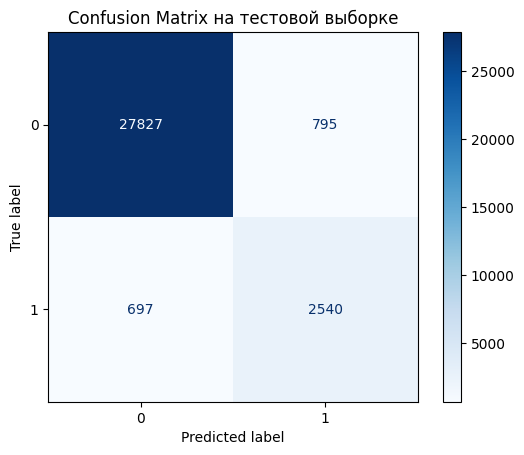

In [32]:
cm = confusion_matrix(y_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix на тестовой выборке')
plt.show()

На тестовых данных данных модель удовлетворяет метрики *f1-score*(0.77). Токсичные комментарии, определенные моделью, на 24%  состоят из ложноположительных, в тоже время около 21% токсичных модель не удается отследить верно.

## Выводы

Данный проект был проведен для создания классификационной модели по определению тональности комментариев интернет магазина **Викишоп**. 

Перед тем как приступить к подбору классификационной модели была проведена подготовка текста:
1. Очистка текста от ненужных символов.
2. Проведена лемматизация текстов комментариев.
3. Разбиение текста на токены - в одно и два слова.
3. Векторизация текстов путем использования подсчета использования токенов в текстах.

После этого из трех моделей: *LogisticRegression*, *LinearSVC* и *LGBMClassifier* была выбрана наиболее подходящая по метрике **f1-score** модель. Перед этим в каждой модели были подобраны комбинации гиперпараметров, позволяющих получить максимальное значение ф-меры. Так были получены следующие результаты:
+ *LogisticRegression*: 0.77 на тренировочной и 0.78 на валидационной выборках;
+ *LinearSVC*: 0.77 на тренировочной и 0.78 на валидационной выборках;
+ *LGBMClassifier*: 0.74 на тренировочной и 0.74 на валидационной выборках.

В итоге в качестве исполняющей модели была выбрана модель *LinearSVC*, которая имела практически одинаковый результат в метриках с *LogisticRegression*, однако превосходила по скорости обучения в 9 раз.

В финальном тестировании выбранная модель, основанная на методе опорных векторов показала следуюшие результаты:
+ **f1-score**:  0.773
+ **recall**: 0.785
+ **precision**: 0.761.

Данные результаты показывают, что модель правильно находит 78,5% токсичных комментариев, однако сбалансированная ф-мера превышает пороговое значение, установленное заказчиком. 